# Transfer Learning Tutorial

- http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- なぜアリとハチ・・・犬と猫がいいよ〜
- 犬と猫もやろう！！！

- VGG16のFine-tuningによる犬猫認識 (2)
- http://aidiary.hatenablog.com/entry/20170110/1484057655

- 大規模なCNNをスクラッチ（ランダムな初期重み）から学習させられる人は少ない
- 大規模なデータとマシンパワーが必要になるため
- 一般的にはImageNetなので学習済みのネットワークを使うことが多い
- Finetuning the convnet: ImageNetで学習済みのモデルを初期重みとして学習する
- ConvNet as fixed feature extractor: 出力層以外の学習済みモデルの重みは固定する。出力層のみタスクに合わせて置き換えてそこのみ学習する

In [64]:
%matplotlib inline

In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

- アリとハチを分類するモデルを学習する
- 訓練画像は244枚、バリデーション画像は153枚（ImageNetのサブセット）
- スクラッチから学習するには少なすぎるがTransfer Learningは可能

## Load Data

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data/

--2018-02-05 11:53:06--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org... 54.230.111.199, 54.230.111.66, 54.230.111.171, ...
Connecting to download.pytorch.org|54.230.111.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  4.55MB/s    in 14s     

2018-02-05 11:53:21 (3.20 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
!ls data

cifar-10-batches-py    hymenoptera_data.zip   processed
cifar-10-python.tar.gz mnist                  raw
dancing.jpg            picasso.jpg            train.txt


In [ ]:
!cd data/
!unzip data/hymenoptera_data.zip -d data/

### データ拡張のテスト

- 画像フォルダからデータをPIL形式で読み込むには `ImageFolder`

In [47]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
print(len(image_dataset))
image, label = image_dataset[0]

244


#### RandomResizedCrop

Crop the given PIL Image to random size and aspect ratio.

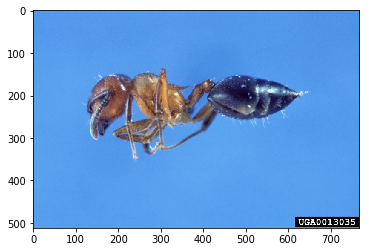

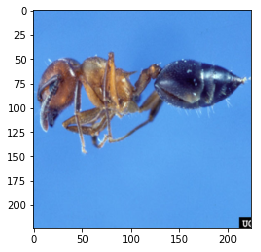

In [48]:
plt.figure()
plt.imshow(image)

t = transforms.RandomResizedCrop(224)
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

#### RandomHorizontalFlip

Horizontally flip the given PIL Image randomly with a probability of 0.5.

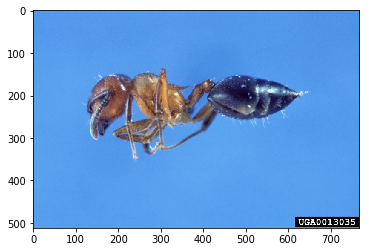

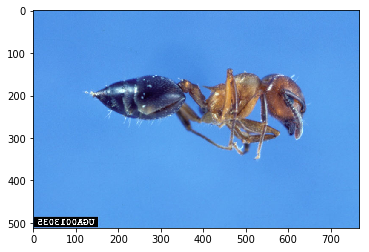

In [53]:
plt.figure()
plt.imshow(image)

t = transforms.RandomHorizontalFlip()
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

#### Resize

Resize the input PIL Image to the given size.

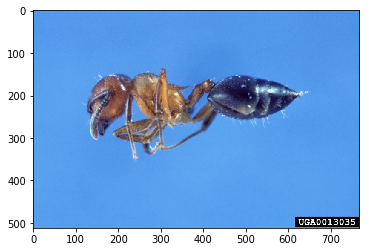

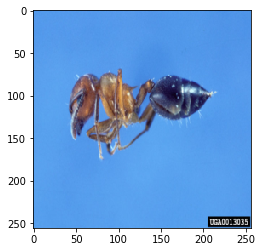

In [57]:
plt.figure()
plt.imshow(image)

t = transforms.Resize((256, 256))
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

#### CenterCrop

Crops the given PIL Image at the center.

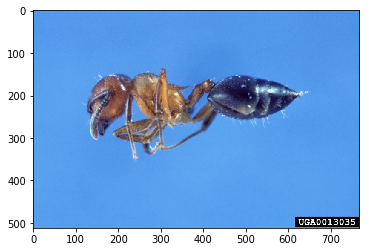

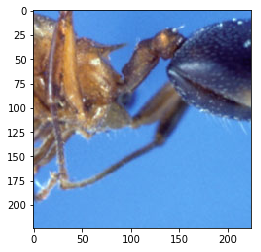

In [63]:
plt.figure()
plt.imshow(image)

t = transforms.CenterCrop(224)
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

#### 全部入り

- 訓練とバリデーションで使う拡張はわける
- 訓練は汎化性能が上がるようにRandomCropやFlipを入れる
- バリデーションは入力画像のサイズがネットワークに合うようにサイズを変形する
- `Normalize()` はImageNetの訓練データの平均と分散
- ImageNetで訓練済みのニューラルネットを使うのでデータ標準化方法をあわせる必要がある

In [66]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

- DataSetとDataLoaderを作成
- trainとvalを同じ辞書にいれてキーで区別するようにしている
- `ImageFolder` はKerasのImageDataGeneratorのflow_from_directory()に近い
- ディレクトリをクラスごとにわけて画像を置くと自動的にクラスを認識してくれる

In [84]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [86]:
print(image_datasets['train'])
print(image_datasets['val'])
print(dataloaders['train'])
print(dataloaders['val'])
print(dataset_sizes)
print(class_names)

{'train': 244, 'val': 153}
['ants', 'bees']


### Visualize a few images

- DataLoaderでImageNetの平均を引いて標準偏差で割っているので元のピクセルに戻すために逆演算している

torch.Size([4, 3, 224, 224]) torch.Size([4])


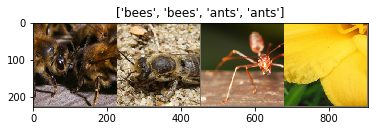

In [92]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))  # (h, w, c)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())  # torch.Size([4, 3, 224, 224]) torch.Size([4])
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

## Training the model

- running_lossはミニバッチ数に含まれるサンプル数倍したものを加えていく
- 最後に全サンプル数で割って平均を求めている

In [107]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Finetuning the convnet

- 出力層を置き換えて、重みを固定せずに新規データでチューニングする
- 学習済みのResNet18をロード
- 最後のfc層が1000クラスなのでそのままでは使えない
- 最後のfc層を2クラス出力するように置き換える

In [95]:
model_ft = models.resnet18(pretrained=True)

In [96]:
model_ft

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [99]:
num_features = model_ft.fc.in_features
print(num_features)

512


- 層の置き換えはすごく簡単！

In [100]:
# fc層を置き換える
model_ft.fc = nn.Linear(num_features, 2)

In [101]:
model_ft

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNo

In [ ]:
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 7エポックごとに学習率を0.1倍する
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(model_ft.state_dict(), 'model_ft.pkl')

```
Epoch 20/24
----------
train Loss: 0.2950 Acc: 0.8689
val Loss: 0.2302 Acc: 0.9020

Epoch 21/24
----------
train Loss: 0.2466 Acc: 0.8893
val Loss: 0.2107 Acc: 0.9281

Epoch 22/24
----------
train Loss: 0.3057 Acc: 0.8648
val Loss: 0.2204 Acc: 0.9216

Epoch 23/24
----------
train Loss: 0.2220 Acc: 0.9180
val Loss: 0.2031 Acc: 0.9281

Epoch 24/24
----------
train Loss: 0.3338 Acc: 0.8648
val Loss: 0.2066 Acc: 0.9216

Training complete in 1m 60s
Best val acc: 0.9281
```

## Visualizing the model predictions

- GPU上で学習したモデル重みをCPUに持ってくるとき
- そのままやると `AssertionError: Torch not compiled with CUDA enabled`
- map_locationとlocを指定すればOK
- https://discuss.pytorch.org/t/loading-weights-for-cpu-model-while-trained-on-gpu/1032

In [115]:
# GPUで学習したモデルのロード
model_ft.load_state_dict(torch.load('model_ft.pkl', map_location=lambda storage, loc: storage))

In [128]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

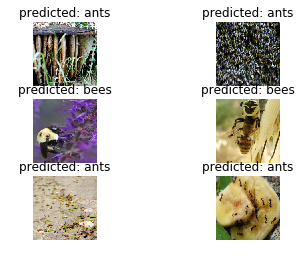

In [129]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor

- 出力層を除いたネットワークの重みを固定（freeze）する
- 誤差逆伝搬法で誤差を伝搬しないようにするには `requires_grad = False` とする

In [133]:
# 訓練済みResNet18をロード
model_conv = torchvision.models.resnet18(pretrained=True)

# すべてのパラメータを固定
for param in model_conv.parameters():
    param.requires_grad = False

# 最後のfc層を置き換える
# これはデフォルトの requires_grad=True のままなのでパラメータ更新対象
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Optimizerの第1引数には更新対象のfc層のパラメータのみ指定
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

- 勾配はネットワークの大部分で計算しなくて済むため前に比べて学習は早い
- しかし、lossを計算するためforwardは計算しないといけない

In [134]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6291 Acc: 0.6885
val Loss: 0.4383 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.4950 Acc: 0.7951
val Loss: 0.4239 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.4388 Acc: 0.7951
val Loss: 0.3406 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.6833 Acc: 0.7295
val Loss: 0.1905 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5576 Acc: 0.7582
val Loss: 0.2137 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3898 Acc: 0.8320
val Loss: 0.2083 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3067 Acc: 0.8607
val Loss: 0.2083 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3569 Acc: 0.8402
val Loss: 0.2107 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4256 Acc: 0.8115
val Loss: 0.2114 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3473 Acc: 0.8402
val Loss: 0.1958 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3621 Acc: 0.8279
val Loss: 0.2419 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3787 Acc: 0.7992
val Loss: 0.2111 Acc: 0.9346

Ep

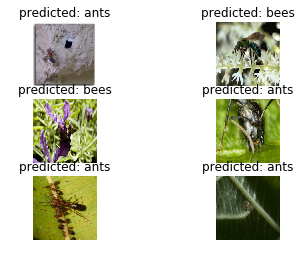

In [135]:
visualize_model(model_conv)